## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [0]:
!mkdir /data
!mkdir /models
!mkdir /data/data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data/data

In [0]:
#import libraries

import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import glob 
from PIL import Image
import matplotlib.image as mpimg
import os 
import torch
import random
from models import FaceNet
from data_load import Rescale, RandomCrop, Normalize, ToTensor, FacialKeypointsData

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 0
seed_everything(seed)

In [0]:
model = FaceNet()
print (model)

FaceNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d1): Dropout(p=0.2, inplace=False)
  (conv6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d2): Dropout(p=0.2, inplace=False)
  (conv8): Conv2d(64, 128, kernel

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [0]:
#Transformed Datasets
from torchvision import transforms, utils
from torch.utils.data import DataLoader

transform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(),ToTensor()])
train_data = FacialKeypointsData('/data/data/training_frames_keypoints.csv','/data/data/training',transform = transform)
test_data = FacialKeypointsData('/data/data/test_frames_keypoints.csv','/data/data/test',transform = transform)


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [0]:
batch_size = 64
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=1,shuffle=False)
print (len(train_data),len(test_data))

3462 770


## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

In [0]:
def test_model(n_samples = 1):
  with torch.no_grad():
    model.eval()
    fig = plt.figure()
    for i,sample in enumerate(test_loader):
      image = sample['image']
      image = image.type(torch.FloatTensor)
      key_pts = sample['key_pts'].squeeze(0)
      pred_pts = model(image)
      pred_pts = pred_pts.squeeze(0).view(68,2)
      image = image.squeeze(0).squeeze(0).numpy()   
      pred_pts = pred_pts.numpy()
      # undo normalization of keypoints  
      pred_pts = pred_pts*50.0+100
      key_pts = key_pts.numpy()
      # undo normalization of keypoints  
      key_pts = key_pts*50.0+100
      
      ax = plt.subplot(1,n_samples,i+1)
      show_all_points(image,key_pts,pred_pts)
      if i == n_samples - 1:
        break

def show_all_points(image,key_pts,pred_pts=None):
  plt.imshow(image,cmap='gray')
  plt.scatter(key_pts[:,0],key_pts[:,1],s=20,marker='.',c='m')
  if pred_pts is not None:
    plt.scatter(pred_pts[:,0],pred_pts[:,1],s=20,marker='.',c='g')


#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

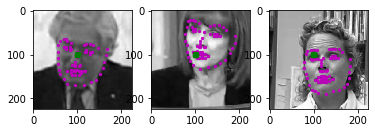

In [0]:
test_model(3)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [0]:
import torch.optim as optim
import torch.nn as nn
model = FaceNet()
opt = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.L1Loss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [0]:
def train_net_cust(epochs,model_name):
  train_loss = list()
  test_loss = list()
  limit = 7
  best_loss = 500 
  print ('starting training')
  for e in range(epochs):
    if limit == 0:
      print ('early stopping at epoch = %r max_performance at epoch = %r' %(e,e-7))
      break
    model.to(device)
    model.train()
    running_loss = 0.0
    for samples in iter(train_loader):
      images = samples['image'].type(torch.FloatTensor).to(device)
      label_pts = samples['key_pts'].type(torch.FloatTensor).to(device)
      pred_pts = model(images)
      pred_pts = pred_pts.view(pred_pts.shape[0],68,2)
      opt.zero_grad()
      # print (pred_pts.shape,label_pts.shape)
      loss = criterion(label_pts,pred_pts)
      loss.backward()
      opt.step()
      running_loss += loss.item()
    train_loss.append(running_loss)
    print ("training epoch = %r loss = %r" %(e,running_loss))
    running_loss = 0.0 
    with torch.no_grad():
      model.eval()
      for samples in iter(test_loader):
        images = samples['image'].type(torch.FloatTensor).to(device)
        label_pts = samples['key_pts'].type(torch.FloatTensor).to(device)
        pred_pts = model(images)
        pred_pts = pred_pts.view(pred_pts.shape[0],68,2)
        loss = criterion(label_pts,pred_pts)
        running_loss += loss.item()
      test_loss.append(running_loss)
      print ("testing epoch = %r loss = %r" %(e,running_loss))
      model.to("cpu")
      if running_loss <= best_loss:
        best_loss = running_loss 
        limit = 7
        torch.save(model.state_dict(),'/models/model.pt')
      else:
        limit = limit - 1
  print ('completed training')
  model.to("cpu")
  f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
  f.suptitle(model_name)
  ax1.set_title('train_loss')
  ax1.plot(range(0,len(train_loss)),train_loss)
  ax2.set_title('test_loss')
  ax2.plot(range(0,len(test_loss)),test_loss)


starting training
training epoch = 0 loss = 38.56892031431198
testing epoch = 0 loss = 431.6217721402645
training epoch = 1 loss = 36.150629103183746
testing epoch = 1 loss = 448.3402052819729
training epoch = 2 loss = 34.92332303524017
testing epoch = 2 loss = 449.3301411867142
training epoch = 3 loss = 33.74969929456711
testing epoch = 3 loss = 408.9740945994854
training epoch = 4 loss = 32.44292414188385
testing epoch = 4 loss = 402.96194188296795
training epoch = 5 loss = 30.883856773376465
testing epoch = 5 loss = 450.36831840872765
training epoch = 6 loss = 28.947436273097992
testing epoch = 6 loss = 375.51926079392433
training epoch = 7 loss = 26.669067829847336
testing epoch = 7 loss = 312.22059827297926
training epoch = 8 loss = 23.844753950834274
testing epoch = 8 loss = 259.41822297126055
training epoch = 9 loss = 20.941033959388733
testing epoch = 9 loss = 243.40596053749323
training epoch = 10 loss = 18.7414513528347
testing epoch = 10 loss = 263.6884199902415
training epo

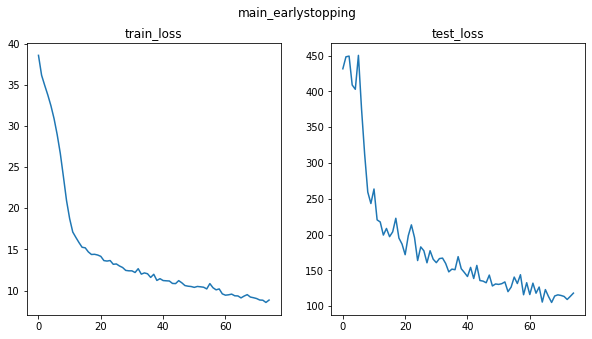

In [0]:
train_net_cust(100,'main_earlystopping')

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [0]:
model.load_state_dict(torch.load('/models/model.pt'))

<All keys matched successfully>

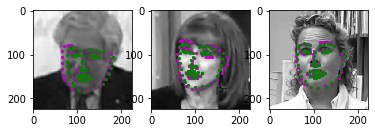

In [0]:
test_model(3)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


For the optimizer, I chose, Adam optimizer as it provides the best performance on average. For loss function, I chose, L1 Loss to train my model. 
Upon comparing models trained with L1 and L2 loss, I found out L1 loss trained models to perform better as compared to L2 Loss. 


### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

I had started with a very simple CNN model with only 4 convolution layers. I saw a performance increase on adding more convolution layers. I also saw an increase on using two fully connected layers. 
Experimenting with the activation functions, I found out leaky relu with a negative slope of 0.3 performs better than the standard ReLU activation function based models. 
BatchNormalization and dropout also helped the model learn a better representation of data.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?


I experimented with different batch sizes and found out that batch size of 64 images worked well. 
For the epochs I tried increasing epochs from 8 to 30 then to 50. I saw a performance increase every time. Then I implemeted early stopping for the model with a patience of 7 epochs. This helped find the model with the best performance instead of guessing the number of epochs. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

<Figure size 720x360 with 0 Axes>

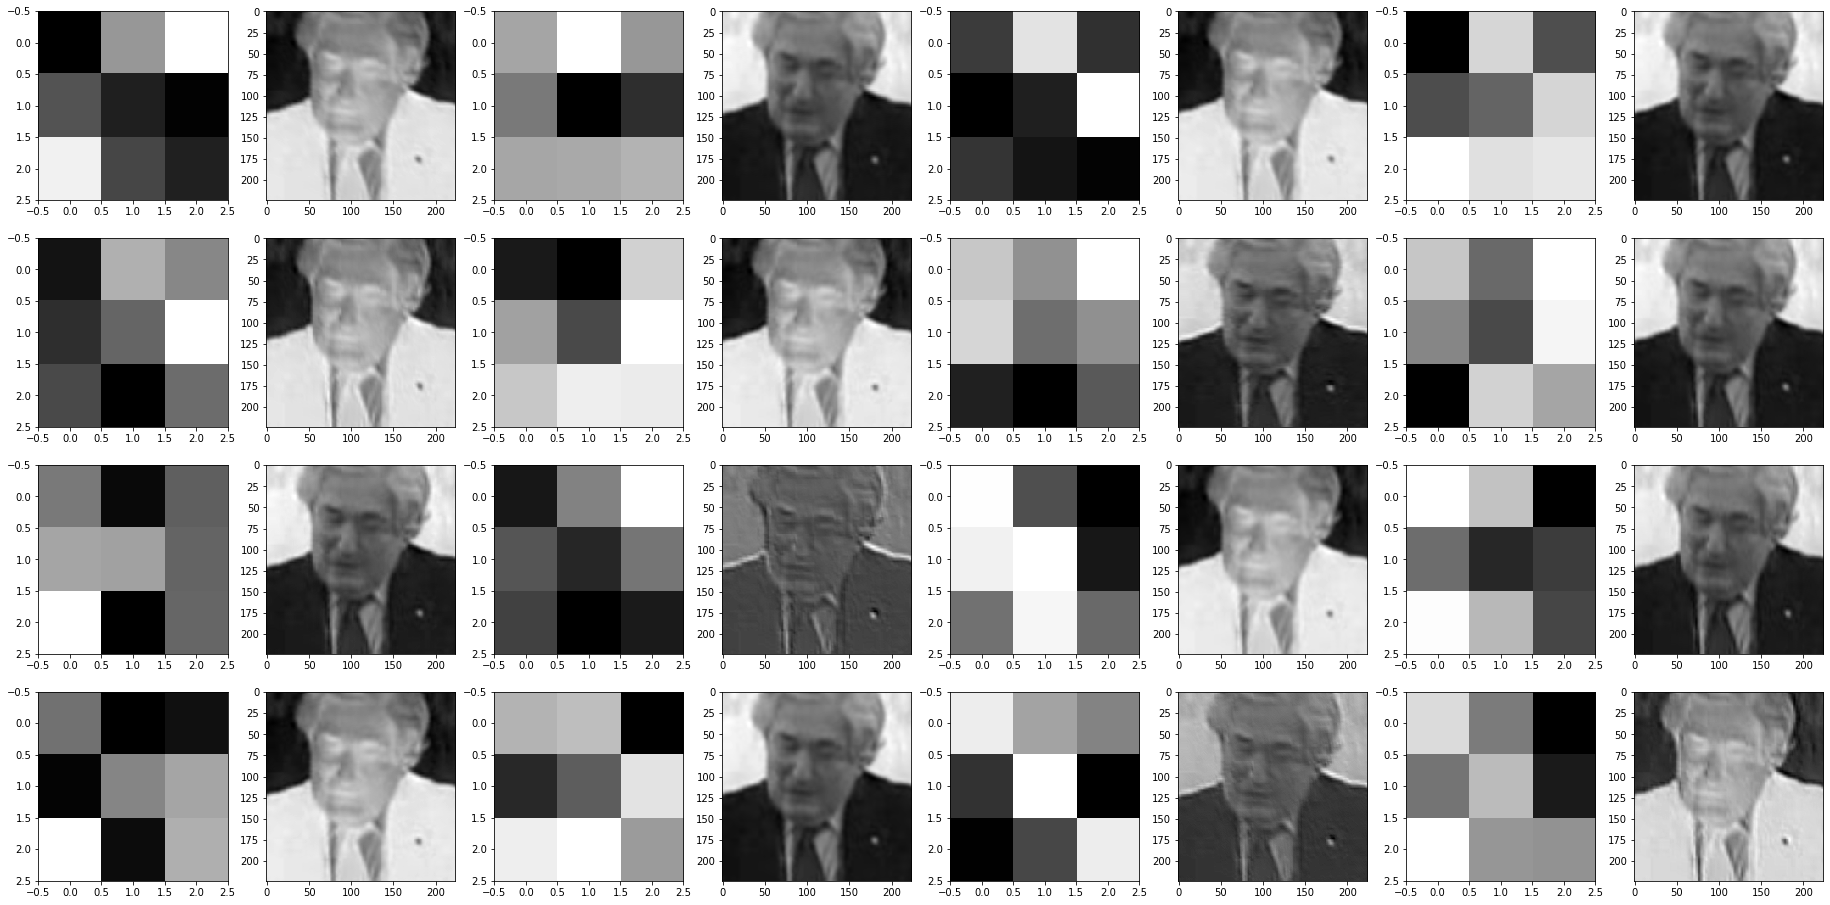

In [0]:
def feature_viz(n_samples=1):
    fig = plt.figure(figsize=(10,5))
    with torch.no_grad():
      weight_second = model.conv2.weight.data.numpy()
      for idx,sample in enumerate(test_loader):
        image = sample['image']
        image = image.type(torch.FloatTensor)
        image = image.squeeze(0).squeeze(0).numpy()
        fig = plt.figure(figsize=(32,16))
        cols = 8
        rows = 4
        for i in range(0,32):
          fig.add_subplot(rows,cols,i+1)
          if i % 2 == 0:
            plt.imshow(weight_second[int(i/2)][0],cmap='gray')
          else:
            viz_filter = cv2.filter2D(image,-1,weight_second[int((i-1)/2)][0])
            plt.imshow(viz_filter,cmap='gray')
        if idx == n_samples - 1:
          break

feature_viz()

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


I chose filters from second convolution layers. Observing the output on using OpenCv's filter2d funcion, I saw that the lines around the edges of the body of the person were white and overall the feature tried to differentiate between the background and the foreground using this demarcation. 

Another filter highlighted the featires of the face around the eyes and the lips. So this filter would be used by the networ to detect areas around the eyes and lips, measured by the intensity differences in vertical region as shown by the filter image. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!